In [1]:
%matplotlib inline

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

In [2]:
mnist_data = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_data.load_data()

11501568/11490434 [==============================] - 3s 0us/step


In [10]:
# 'sparse_categorical_crossentropy'은 y[0]=9, y[1]=0 과 같이 one-hot-encoding이 안되어있는 label일 경우에 사용
# 'categorical_crossentropy'은 y[0]=[0, 0, 0, 0, 0, 0, 0, 0, 1], y[1, 0, 0, 0, 0, 0, 0, 0, 0]과 같이 one-hot-encoding label일 경우에 사용

print(train_labels.max())
print(train_labels.min())
print(test_labels.max())
print(test_labels.min())

9
0
9
0


In [3]:
def scale_mnist_data(train_images, test_images):

    train_images = train_images / 255.
    test_images = test_images / 255.

    return train_images, test_images

In [4]:
scaled_train_images, scaled_test_images = scale_mnist_data(train_images, test_images)

In [5]:
print(scaled_train_images.shape)
print(scaled_test_images.shape)

(60000, 28, 28)
(10000, 28, 28)


In [6]:
# Add a dummy channel dimension
scaled_train_images = scaled_train_images[..., np.newaxis]
scaled_test_images = scaled_test_images[..., np.newaxis]

In [7]:
print(scaled_train_images.shape)
print(scaled_test_images.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [8]:
def get_model(input_shape):

    model = Sequential([
        Conv2D(8, (3, 3), padding='same', activation='relu', strides = 1, input_shape=input_shape, data_format='channels_last'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax'),    
    ])

    return model

In [11]:
model = get_model(scaled_train_images[0].shape)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 8)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 64)                100416    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                        

In [13]:
def compile_model(model):

    opt = tf.keras.optimizers.Adam(learning_rate=0.005)
    acc = tf.keras.metrics.SparseCategoricalAccuracy()
    mae = tf.keras.metrics.MeanAbsoluteError()

    model.compile(optimizer = opt, 
                  loss = 'sparse_categorical_crossentropy', 
                  metrics = ['accuracy'])
    

In [14]:
compile_model(model)

In [16]:
def train_model(model, scaled_train_images, train_labels, epoch=5, verbose=1):
    
    history = model.fit(scaled_train_images, train_labels, epochs=epoch, verbose=verbose)
    return history

In [17]:
history = train_model(model, scaled_train_images, train_labels)

Epoch 1/5
1875/1875 [==============================] - 12s 4ms/step - loss: 0.1629 - accuracy: 0.9506
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0743 - accuracy: 0.9774
Epoch 3/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0545 - accuracy: 0.9835
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0465 - accuracy: 0.9862
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0376 - accuracy: 0.9888


In [18]:
frame = pd.DataFrame(history.history)

[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Accuracy')]

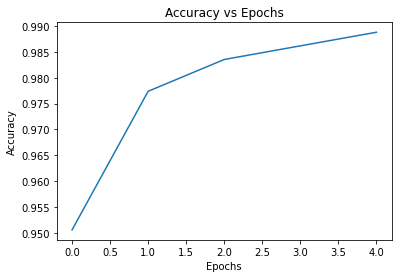

In [19]:
acc_plot = frame.plot(y="accuracy", title="Accuracy vs Epochs", legend=False)
acc_plot.set(xlabel="Epochs", ylabel="Accuracy")

[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Loss')]

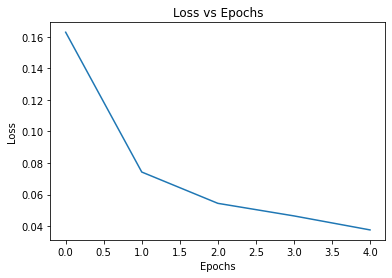

In [20]:
acc_plot = frame.plot(y="loss", title = "Loss vs Epochs",legend=False)
acc_plot.set(xlabel="Epochs", ylabel="Loss")

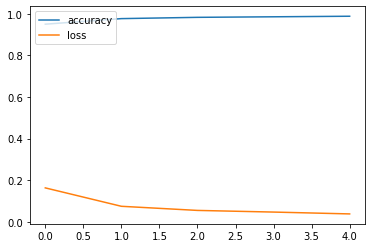

In [21]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.legend(loc='upper left')
plt.show()

In [22]:
def evaluate_model(model, scaled_test_images, test_labels):

    loss, accuracy = model.evaluate(scaled_test_images, test_labels)
    return loss, accuracy

In [23]:
test_loss, test_accuracy = evaluate_model(model, scaled_test_images, test_labels)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

313/313 [==============================] - 1s 4ms/step - loss: 0.0946 - accuracy: 0.9770
Test loss: 0.09459094703197479
Test accuracy: 0.9769999980926514


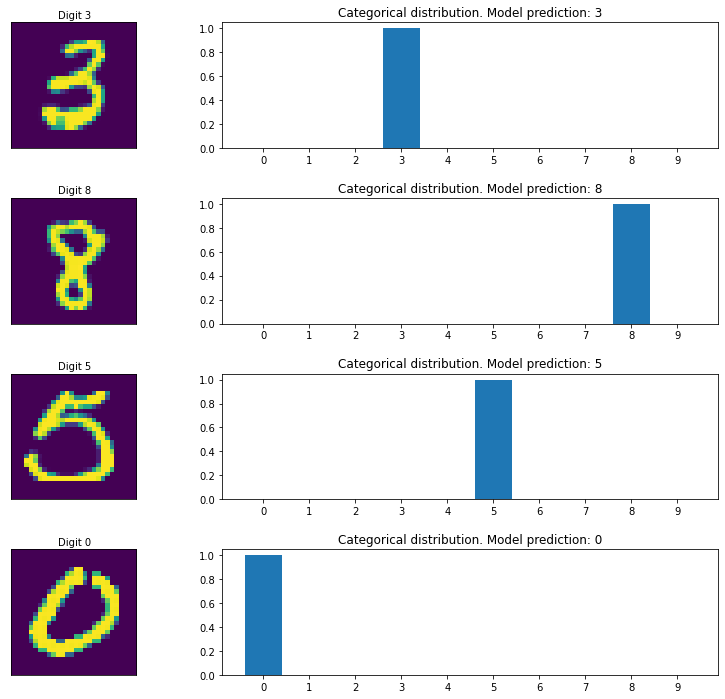

In [24]:
num_test_images = scaled_test_images.shape[0]

random_inx = np.random.choice(num_test_images, 4)
random_test_images = scaled_test_images[random_inx, ...]
random_test_labels = test_labels[random_inx, ...]

predictions = model.predict(random_test_images)

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")
    
plt.show()